# Implementing Dropout

In this notebook, we will implement dropout.  Our goal is to acheive over 55% accuracy on CIFAR-10, using dropout and batch normalization.

`utils` has built a solid API for building these modular frameworks and training them, and we will use their very well implemented framework as opposed to "reinventing the wheel."  This includes using their Solver, various utility functions, and their layer structure.  This also includes `nndl.fc_net`, `nndl.layers`, and `nndl.layer_utils`.

In [ ]:
## Import and setups
from google.colab import drive
drive.mount('/content/drive')
import time
import numpy as np
import matplotlib.pyplot as plt
from nndl.fc_net import *
from nndl.layers import *
from utils.data_utils import get_CIFAR10_data
from utils.gradient_check import eval_numerical_gradient, eval_numerical_gradient_array
from utils.solver import Solver

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

Mounted at /content/drive


In [ ]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k in data.keys():
  print('{}: {} '.format(k, data[k].shape))

X_train: (49000, 3, 32, 32) 
y_train: (49000,) 
X_val: (1000, 3, 32, 32) 
y_val: (1000,) 
X_test: (1000, 3, 32, 32) 
y_test: (1000,) 


## Dropout forward pass

Let us implement the training and test time dropout forward pass, `dropout_forward`, in `nndl/layers.py`.
Then, we check the results using the following cell.

In [ ]:
x = np.random.randn(500, 500) + 10

for p in [0.3, 0.6, 0.75]:
  out, _ = dropout_forward(x, {'mode': 'train', 'p': p})
  out_test, _ = dropout_forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean())
  print('Mean of train-time output: ', out.mean())
  print('Mean of test-time output: ', out_test.mean())
  print('Fraction of train-time output set to zero: ', (out == 0).mean())
  print('Fraction of test-time output set to zero: ', (out_test == 0).mean())

Running tests with p =  0.3
Mean of input:  10.001139790218593
Mean of train-time output:  9.992868868590305
Mean of test-time output:  10.001139790218593
Fraction of train-time output set to zero:  0.300692
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.6
Mean of input:  10.001139790218593
Mean of train-time output:  10.001640461586655
Mean of test-time output:  10.001139790218593
Fraction of train-time output set to zero:  0.600048
Fraction of test-time output set to zero:  0.0
Running tests with p =  0.75
Mean of input:  10.001139790218593
Mean of train-time output:  9.976662515470968
Mean of test-time output:  10.001139790218593
Fraction of train-time output set to zero:  0.750528
Fraction of test-time output set to zero:  0.0


## Dropout backward pass

Let us implement the backward pass, `dropout_backward`, in `nndl/layers.py`. Then, we check the results using the following cell.

In [ ]:
x = np.random.randn(10, 10) + 10
dout = np.random.randn(*x.shape)

dropout_param = {'mode': 'train', 'p': 0.8, 'seed': 123}
out, cache = dropout_forward(x, dropout_param)
dx = dropout_backward(dout, cache)
dx_num = eval_numerical_gradient_array(lambda xx: dropout_forward(xx, dropout_param)[0], x, dout)

print('dx relative error: ', rel_error(dx, dx_num))

dx relative error:  1.892910063991483e-11


## Implementing a fully connected neural network with dropout layers

Let us modify the `FullyConnectedNet()` class in `nndl/fc_net.py` to incorporate dropout.  A dropout layer will be incorporated after every ReLU layer.
Then, we check the results using the following cell.

In [ ]:
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = np.random.randn(N, D)
y = np.random.randint(C, size=(N,))

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dtype=np.float64,
                            dropout=dropout, seed=123)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = eval_numerical_gradient(f, model.params[name], verbose=False, h=1e-5)
    print('{} relative error: {}'.format(name, rel_error(grad_num, grads[name])))
  print('\n')

Running check with dropout =  0
Initial loss:  2.303043161170242
W1 relative error: 4.795196815215288e-07
W2 relative error: 1.9717710574314515e-07
W3 relative error: 1.5587099483501822e-07
b1 relative error: 2.033615448560775e-08
b2 relative error: 1.686315567518667e-09
b3 relative error: 1.1144421861081857e-10


Running check with dropout =  0.25
Initial loss:  2.305774818835151
W1 relative error: 1.8156244375172108e-07
W2 relative error: 6.897148854646911e-07
W3 relative error: 1.9695957408191714e-07
b1 relative error: 1.7241181656398422e-08
b2 relative error: 3.3429867864564094e-09
b3 relative error: 1.8619747824927798e-10


Running check with dropout =  0.5
Initial loss:  2.2994400290646637
W1 relative error: 3.38841535237639e-08
W2 relative error: 8.884395587455194e-08
W3 relative error: 2.3767592670693847e-08
b1 relative error: 9.935222529879073e-10
b2 relative error: 8.032917281149487e-10
b3 relative error: 1.4333807510530193e-10




## Dropout as a regularizer

We know that dropout acts as a regularizer by effectively bagging.  To check this, we will train two small networks, one with dropout and one without dropout.  

In [ ]:
# Train two identical nets, one with dropout and one without

num_train = 500
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

solvers = {}
dropout_choices = [0, 0.6]
for dropout in dropout_choices:
  model = FullyConnectedNet([100, 100, 100], dropout=dropout)

  solver = Solver(model, small_data,
                  num_epochs=25, batch_size=100,
                  update_rule='adam',
                  optim_config={
                    'learning_rate': 5e-4,
                  },
                  verbose=True, print_every=100)
  solver.train()
  solvers[dropout] = solver

(Iteration 1 / 125) loss: 2.300804
(Epoch 0 / 25) train acc: 0.220000; val_acc: 0.168000
(Epoch 1 / 25) train acc: 0.188000; val_acc: 0.147000
(Epoch 2 / 25) train acc: 0.266000; val_acc: 0.200000
(Epoch 3 / 25) train acc: 0.338000; val_acc: 0.262000
(Epoch 4 / 25) train acc: 0.378000; val_acc: 0.278000
(Epoch 5 / 25) train acc: 0.428000; val_acc: 0.297000
(Epoch 6 / 25) train acc: 0.468000; val_acc: 0.323000
(Epoch 7 / 25) train acc: 0.494000; val_acc: 0.287000
(Epoch 8 / 25) train acc: 0.566000; val_acc: 0.328000
(Epoch 9 / 25) train acc: 0.572000; val_acc: 0.322000
(Epoch 10 / 25) train acc: 0.622000; val_acc: 0.324000
(Epoch 11 / 25) train acc: 0.670000; val_acc: 0.279000
(Epoch 12 / 25) train acc: 0.710000; val_acc: 0.338000
(Epoch 13 / 25) train acc: 0.746000; val_acc: 0.319000
(Epoch 14 / 25) train acc: 0.792000; val_acc: 0.307000
(Epoch 15 / 25) train acc: 0.834000; val_acc: 0.297000
(Epoch 16 / 25) train acc: 0.876000; val_acc: 0.327000
(Epoch 17 / 25) train acc: 0.886000; val

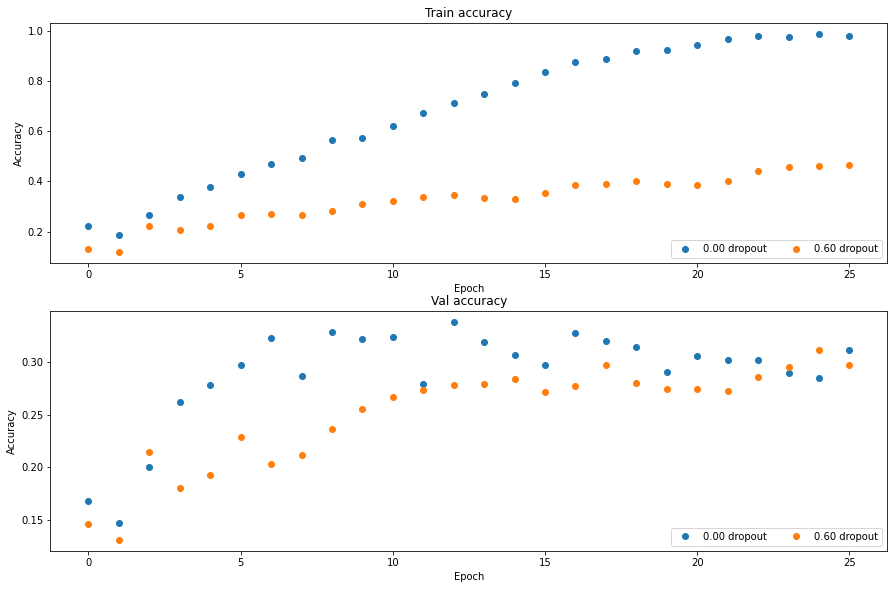

In [ ]:
# Plot train and validation accuracies of the two models

train_accs = []
val_accs = []
for dropout in dropout_choices:
  solver = solvers[dropout]
  train_accs.append(solver.train_acc_history[-1])
  val_accs.append(solver.val_acc_history[-1])

plt.subplot(3, 1, 1)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].train_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for dropout in dropout_choices:
  plt.plot(solvers[dropout].val_acc_history, 'o', label='%.2f dropout' % dropout)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()

## Remark

These two graphs show that when we do not use droupout, the network eventually achieves 100% training accuracy and 30% validation accuracy, which clearly indicates overfitting. On the contrary, when using droupout we see that the network doesn't overfit on the training data since it achieves only 40% accuracy, which shows how the droupout layer acts like a regularizer that forces the network to extract meaningful features and not "learn them by heart".

## Final objective
Let us try and get over 55% validation accuracy on CIFAR-10 by using the layers we implemented.

In [ ]:
# After a gridsearch to optimize our parmeters, we get:

model = FullyConnectedNet([700, 500, 500, 250, 100], dropout=0.5, use_batchnorm = True, weight_scale=0.01)

solver = Solver(model, data,
                num_epochs=30, batch_size=2000,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,'learning_rate_decay': 0.90,
                },
                verbose=True, print_every=100)
solver.train()


(Iteration 1 / 720) loss: 2.306735
(Epoch 0 / 30) train acc: 0.191000; val_acc: 0.178000
(Epoch 1 / 30) train acc: 0.322000; val_acc: 0.291000
(Epoch 2 / 30) train acc: 0.374000; val_acc: 0.384000
(Epoch 3 / 30) train acc: 0.397000; val_acc: 0.422000
(Epoch 4 / 30) train acc: 0.465000; val_acc: 0.457000
(Iteration 101 / 720) loss: 1.574813
(Epoch 5 / 30) train acc: 0.472000; val_acc: 0.465000
(Epoch 6 / 30) train acc: 0.477000; val_acc: 0.498000
(Epoch 7 / 30) train acc: 0.487000; val_acc: 0.486000
(Epoch 8 / 30) train acc: 0.522000; val_acc: 0.505000
(Iteration 201 / 720) loss: 1.479054
(Epoch 9 / 30) train acc: 0.503000; val_acc: 0.510000
(Epoch 10 / 30) train acc: 0.521000; val_acc: 0.507000
(Epoch 11 / 30) train acc: 0.554000; val_acc: 0.521000
(Epoch 12 / 30) train acc: 0.546000; val_acc: 0.517000
(Iteration 301 / 720) loss: 1.385177
(Epoch 13 / 30) train acc: 0.573000; val_acc: 0.521000
(Epoch 14 / 30) train acc: 0.555000; val_acc: 0.532000
(Epoch 15 / 30) train acc: 0.570000; va

In [ ]:
y_test_pred = np.argmax(model.loss(data['X_test']), axis=1)
y_val_pred = np.argmax(model.loss(data['X_val']), axis=1)
print('Best Validation Accuracy {}'.format(np.mean(y_val_pred == data['y_val'])))
print('Test set accuracy: {}'.format(np.mean(y_test_pred == data['y_test'])))

Best Validation Accuracy 0.571
Test set accuracy: 0.581
